# Part 1 intuition behind elastic weight colsolidation

In the figure below, $\theta^{*}$ are the weights (ie parameters, synaptic strengths) learned by the neural network (NN) to solve old task A, shown as a vector in vector space. ie if this neural network as 100 total weights then this is a 2D representation of $\mathbb{R}^{100}$ space. The blue horizontal arrow shows an example of catastrophic forgetting, whereby $\theta^{*}$ moves out of the region that allows the NN to perform well at task A (grey), and into the center of a region that allows the NN to perform well at task B (cream). The downward green arrow is the update to $\theta^{*}$ regularized by L2 penalty $\alpha (\theta_{i} - \theta_{A , i}^{*})^{2}$ that causes it to move toward the cream region irrespective of the shape of the grey region. The desired update vector is the red arrow that moves the NN weights into a region capable of performing well at both tasks A and B. 

How Elastic Weight Cosolidation Changes Learning New Weights $\theta^{*}$
<p align="center">
<img src="https://raw.githubusercontent.com/clam004/intro_continual_learning/main/files/F1.large.jpg" height=500 width=500 >
</p>

EWC encourages movement of weights along the red path by modifying the loss function when re-training a NN that has already been trained to convergence using the loss function for task A, $L_{A}$, which has settled on weights $\theta_{A}$. When re-training the NN on task B using $L_{B}$, we add a term which penalizes changes to weights that are both far from $\theta_{A}$, ie $(\theta_{i} - \theta_{A , i}^{*})^{2}$, and also high in $F_{i}$ which encodes the shape of the grey region.

$$L \left(\right. \theta \left.\right) = L_{B} \left(\right. \theta \left.\right) + \underset{i}{\sum} \frac{\lambda}{2} F_{i} \left(\theta_{i} - \theta_{A , i}^{*}\right)^{2} $$

### But what is F? 

F is the Fisher information matrix. We want to use the diagonal components in Fisher Information Matrix to identify which parameters are more important to task A and apply higher weights to them (the direction of the short axis of grey oval). To learn B we should instead change those weights where F_i is small (long axis of grey oval).  

In the EWC paper:

"we approximate the posterior as a Gaussian distribution with mean given by the parameters θ∗A and a diagonal precision given by the diagonal of the Fisher information matrix F. F has three key properties (20): (i) It is equivalent to the second derivative of the loss near a minimum, (ii) it can be computed from first-order derivatives alone and is thus easy to calculate even for large models, and (iii) it is guaranteed to be positive semidefinite. Note that this approach is similar to expectation propagation where each subtask is seen as a factor of the posterior (21). where LB(θ) is the loss for task B only, λ sets how important the old task is compared with the new one, and i labels each parameter.

When moving to a third task, task C, EWC will try to keep the network parameters close to the learned parameters of both tasks A and B. This can be enforced either with two separate penalties or as one by noting that the sum of two quadratic penalties is itself a quadratic penalty."

### Lets learn what F is in the example

This article gives a very good explaination of F in the context of EWC: [fisher-info-matrix](https://andrewliao11.github.io/blog/fisher-info-matrix/)

To compute F_i, we sample the data from task A once and calculate the empirical Fisher Information Matrix. 

$$
I_{\theta_\mathcal{A}^*} = \frac{1}{N}  \sum_{i=1}^{N} \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*) \nabla_\theta log \ p(x_{\mathcal{A}, i}|\theta_\mathcal{A}^*)^T
$$

This is just to say that the above equation is how you calculate the below equation from the data. For each pair of parameters in $\theta$ ($\theta_i$ and $\theta_j$), the Fisher Information matrix at position ij is

$$
I(\theta)_{ij} = E\left[ \left( \frac{\partial}{\partial\theta_i}\log f(X;\theta) \right)\left( \frac{\partial}{\partial\theta_j}\log f(X;\theta) \right) \mid \theta\right]
$$

If this equation is hard to understand, then the code should make it clearer, dont worry, we will match parts of the code to the equation above so it becomes more tangible.

# Part 2 A look at the data and the task

### MNIST

The MNIST data set contains 70,000 images of handwritten digits and their corresponding labels. The images are 28x28 with pixel values from 0 to 255. The labels are the digits from 0 to 9. By default 60,000 of these images belong to a training set and 10,000 of these images belong to a test set.

### Fashion-MNIST

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

## Task

as you might guess, our goal is to train an NN that retains it's ability to perform well on MNIST after being retrained on only Fashion-MNIST

In [24]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from contlearn.getdata import getMNIST, getFashionMNIST

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
train_loader_mnist, test_loader_mnist = getMNIST(batch_size=64)
train_loader_fashion, test_loader_fashion = getFashionMNIST(batch_size=64)

tensor(3)
torch.Size([28, 28])


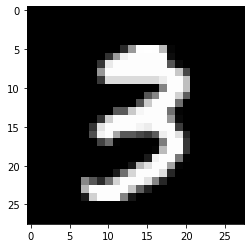

In [32]:
input_image, target_label = next(iter(train_loader_mnist))

print(target_label[0])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)

T-shirt/top
torch.Size([28, 28])


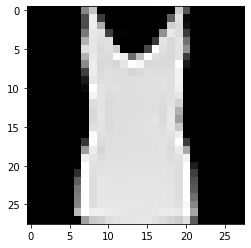

In [40]:
input_image, target_label = next(iter(train_loader_fashion))

fashion_key = {
0: "T-shirt/top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot",
}

print(fashion_key[int(target_label[0].detach().cpu().numpy())])
print(input_image[0][0].shape)

img = Image.fromarray(input_image[0][0].detach().cpu().numpy()*255)

plt.imshow(img)

# Part 3 Baseline results

first we train on MNIST and the we will observe the drop in performance once we retrain on Fashion-MNIST, WITHOUT Elastic Weight Consolidation

In [44]:
import math
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

from contlearn.getmodels import MLP
from contlearn.gettrainer import one_epoch_baseline

%load_ext autoreload
%autoreload 2
%matplotlib inline

print('you are using PyTorch version ',torch.__version__)

if torch.cuda.is_available():
    use_cuda = True
    print("you have", torch.cuda.device_count(), "GPUs")
    device = torch.device("cuda:0")
    print(device)
else:
    use_cuda = False
    print('no GPUs detected')
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
you are using PyTorch version  1.10.0+cu102
you have 2 GPUs
cuda:0


In [42]:
model = MLP(hidden_size=256)

In [ ]:
def baseline_training(model, epochs, use_cuda=True, weight=True):
    
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
        
    loss, acc = {}, {}
    
    for task in ['mnist', 'fashion']:
        
        loss[task] = []
        acc[task] = []
        
        if task == 'mnist':
            train_loader = train_loader_mnist
        else:
            train_loader = train_loader_fashion
            
        
        for _ in tqdm(range(epochs)):
            
            epoch_loss = one_epoch_baseline(model,optimizer,train_loader)
            
            loss[task].append()
            
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader))
        if task == 0 and weight:
            weight = model.state_dict()
    return loss, acc, weight